In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from nuclear_matter.graphs import add_top_order_legend
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from nuclear_matter.stats_utils import *
from nuclear_matter.matter import *
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
import seaborn as sns
import time

%matplotlib inline

In [2]:
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['figure.dpi'] = 150
# mpl.rcParams['font.family'] = 'serif'
# mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')
setup_rc_params()

# Analysis of Nuclear Matter Results (Refactored)

A much cleaner version of the other notebook. It can be easily extended.

First, import the data

In [3]:
Lambda = 450
# Lambda = 500

high_density = True

# filename_low = filename = '../data/all_matter_data.csv'
# filename_high = filename = '../data/all_matter_data_high_density.csv'

filename_low = '../data/all_matter_data.csv'
filename_high = '../data/all_matter_data_high_density_smooth.csv'
# filename_high = '../data/all_matter_data_high_density.csv'
    
data_high_density = InputData(filename_high, Lambda)
data_low_density = InputData(filename_low, Lambda)

if high_density:
    data = data_high_density
else:
    data = data_low_density

# if high_density:
#     df = pd.read_csv('../data/all_matter_data_high_density.csv')
# else:
#     df = pd.read_csv('../data/all_matter_data.csv')
#     # Convert differences to total prediction at each MBPT order
#     mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
#     df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
#     # 'total' is now unnecessary. Remove it.
#     df.pop('total');

In [4]:
data_high_density.density

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26,
       0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34])

In [5]:
low_mask = np.isin(data_high_density.density, data_low_density.density)
low_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [6]:
data_high_density.y_d_2_plus_3bf

array([[16.04204804, 16.36648114, 15.81984698, 15.40695912],
       [17.6550905 , 17.95992591, 17.52919461, 17.06865987],
       [19.11767302, 19.47286116, 19.21598997, 18.64301841],
       [20.47497083, 20.92174688, 20.89935127, 20.18005182],
       [21.75434298, 22.31721628, 22.58231044, 21.70668729],
       [22.97273792, 23.66671932, 24.25885015, 23.23404487],
       [24.14156721, 24.97547037, 25.91810041, 24.76309343],
       [25.26824168, 26.24761174, 27.54659283, 26.28829172],
       [26.3586942 , 27.48697434, 29.13078123, 27.80135927],
       [27.41736843, 28.69657216, 30.65704796, 29.29231544],
       [28.44760486, 29.87889813, 32.11219419, 30.75062687],
       [29.45242103, 31.03630996, 33.48445481, 32.16671749],
       [30.43463558, 32.17093852, 34.76381382, 33.53261981],
       [31.39608193, 33.28433773, 35.94033261, 34.84048073],
       [32.33894928, 34.3778492 , 37.0071609 , 36.08562408],
       [33.26463562, 35.45254656, 37.95738884, 37.26350816],
       [34.17458717, 36.

In [7]:
for attr in ['y_n_2bf', 'y_s_2bf', 'y_d_2bf', 'y_n_3bf', 'y_s_3bf', 'y_d_3bf',
            'y_n_2_plus_3bf', 'y_s_2_plus_3bf', 'y_d_2_plus_3bf']:
    high_attr = getattr(data_high_density, attr)[low_mask]
    low_attr = getattr(data_low_density, attr)
    attr_close = np.allclose(high_attr, low_attr)
    print(attr, attr_close)
    if not attr_close:
        print(high_attr - low_attr)

y_n_2bf False
[[-0.00829373 -0.01012318 -0.01003589 -0.00412811]
 [ 0.01172192  0.0140536   0.0109155   0.00842401]
 [ 0.01007967  0.01472949  0.01461149  0.00871539]
 [ 0.00524257  0.00677017  0.01049064  0.00111831]
 [-0.00367034 -0.00554008 -0.00034193 -0.00505952]
 [-0.00861    -0.01435929 -0.0097594  -0.01342336]
 [-0.01320763 -0.01971207 -0.02117303 -0.01844732]
 [-0.01984255 -0.02277467 -0.02499223 -0.016538  ]
 [-0.01925176 -0.02343498 -0.02642748 -0.01399052]
 [-0.01640471 -0.01482175 -0.02261798 -0.00743225]
 [-0.00233607 -0.00688951 -0.01130534  0.00056663]
 [ 0.00443412  0.00564636  0.00014511  0.0134111 ]
 [ 0.01098833  0.02311226  0.01691973  0.03328283]
 [ 0.04021126  0.04317115  0.04228838  0.05028708]
 [ 0.05465811  0.06318907  0.06615096  0.07060127]
 [ 0.0837814   0.08810067  0.10161211  0.09335593]
 [ 0.09577929  0.11214874  0.12771712  0.1251851 ]]
y_s_2bf False
[[-0.01304824 -0.00137273 -0.02156486 -0.02290084]
 [ 0.01344194  0.00012221  0.02811205  0.02429929]
 [

Now define all of the parameters of the analysis.

In [8]:
orders = np.array([0, 2, 3, 4])

fig_path = 'manuscript_figures'

body2 = 'NN-only'
body23 = 'NN+3N'
body3 = '3N'
body23_appended = 'Appended'

pure_neutron = 'pure'
sym_nuclear = 'sym'
# avg_momentum = 'avg'
s2_energy = 's2'


# excluded = np.array([1])
# excluded_2bf = np.array([1])
excluded = np.array([0, 1])
excluded_2bf = np.array([0, 1])
# excluded = np.array([1, 3])
# excluded_2bf = np.array([1, 3])
excluded_3bf = np.array([0, 1, 2])

savefigs = True

Lb = 600

breakdown_min = 300
breakdown_max = 1000
breakdown_num = 101
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

ls_min = 0.15
ls_max = 1.5
ls_num = 75
ls_vals = np.linspace(ls_min, ls_max, ls_num)
# ls_min = ls_max = ls_num = ls_vals = None


# The Gaussian process parameters
nugget = 5e-4

kernel = RBF(length_scale=1, length_scale_bounds=(5e-2, 1.5)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel_theta = kernel.theta
ref_2bf = 16

# hyperparams = dict(
#     center=0,
#     disp=0,
#     df=0,
#     scale=1,
# )

df = 10
scale = (df - 2) / df  # Sets expected value to 1

hyperparams = dict(
    center=0,
    disp=0,
    df=df,
    scale=scale,
)

# optimizer = None

In [9]:
kf_n = data.kf_n
Kf_n = data.Kf_n
kf_s = data.kf_s
Kf_s = data.Kf_s

# TESTING
# kf_s = kf_n
# Kf_s = Kf_n

kf_d = data.kf_avg
Kf_d = data.Kf_avg

density = data.density

ref_2bf = data.ref_2bf
ref_n_3bf = data.ref_n_3bf
ref_s_3bf = data.ref_s_3bf
ref_d_3bf = data.ref_avg_3bf

y_s_2_plus_3bf = data.y_s_2_plus_3bf
y_n_2_plus_3bf = data.y_n_2_plus_3bf
y_d_2_plus_3bf = data.y_d_2_plus_3bf

y_s_2bf = data.y_s_2bf
y_n_2bf = data.y_n_2bf
y_d_2bf = data.y_d_2bf

y_s_3bf = data.y_s_3bf
y_n_3bf = data.y_n_3bf
y_d_3bf = data.y_d_3bf

fit_n2lo = data.fit_n2lo
fit_n3lo = data.fit_n3lo

In [10]:
density

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26,
       0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34])

In [11]:
sat_idx = density == 0.16

In [12]:
sat_idx

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [13]:
y_n_2_plus_3bf[sat_idx]

array([[18.19490207, 13.35255828, 18.01825373, 17.49196944]])

In [14]:
# plt.plot(kf_n, y_n_2_plus_3bf[:, 0] / (16 * (kf_n / kf0_n)**2))
# plt.ylim(-2, 2)

In [15]:
# y_s_2_plus_3bf[low_mask] = data_low_density.y_s_2_plus_3bf
# y_s_2bf[low_mask] = data_low_density.y_s_2bf
# y_s_3bf[low_mask] = data_low_density.y_s_3bf

In [16]:
if high_density:
#     train = slice(None, None, 5)
    train = slice(2, None, 5)
#     valid = slice(4, None, 7)
    valid = [(i-2) % 5 == 2 for i in range(len(density))]
else:
    train = slice(None, None, 4)
    valid = slice(2, None, 4)

In [17]:
# orders = np.array([0, 2, 3, 4])
# # body = 'NN-only'
# # body = 'NN+3N'
# Lambda = 450
# fits = {450: [1, 7], 500: [4, 10]}
# train1 = slice(None, None, 5)
# valid1 = slice(2, None, 5)
# # valid1 = np.array([i % 5 != 0 for i in range(len())])
# [fit_n2lo, fit_n3lo] = fits[Lambda]

# excluded = np.array([0, 1])

# savefigs = False

# Lb = 600

# breakdown_min = 300
# breakdown_max = 1000
# breakdown_num = 100
# Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
# Lb_logprior_vals = Lb_logprior(Lb_vals)

# ls_min = 0.1
# ls_max = 1.5
# ls_num = 50
# ls_vals = np.linspace(ls_min, ls_max, ls_num)
# # ls_min = ls_max = ls_num = ls_vals = None

# nugget = 1e-8

# kernel1 = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# # kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
# #     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1_theta = kernel1.theta
# ref1 = 16

# hyperparams = dict(
#     center=0,
#     disp=0,
# #     df=1,
# #     scale=1
#     sd=2
# )


# mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

# mask1 = \
# #     (df['Body'] == body) & \
#     mask_fit & \
#     (df['Lambda'] == Lambda)


# # df_fit = df[mask_fit]
# df_n = df[mask1 & (df['x'] == 0)]
# df_s = df[mask1 & (df['x'] == 0.5)]

# kf_n = df_n[(df_n['OrderEFT'] == 'LO') & (df_n['Body'] == 'NN-only')]['kf'].values
# kf_s = df_s[(df_s['OrderEFT'] == 'LO') & (df_s['Body'] == 'NN-only')]['kf'].values
# density = df_n[(df_n['OrderEFT'] == 'LO') & (df_n['Body'] == 'NN-only')]['n'].values
# kf_d = kf_n.copy()

# # valid1 = np.arange(len(kf_n)) % 5 != 0

# Kf_n = kf_n[:, None]
# Kf_s = kf_s[:, None]
# Kf_d = kf_d[:, None]

# kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 100)
# Kf_s_dense = kf_s_dense[:, None]

# if not high_density:
#     kf_n_dense = np.linspace(kf_n.min(), kf_n.max(), 100)
#     Kf_n_dense = kf_n_dense[:, None]

#     kf_d_dense = np.linspace(kf_d.min(), kf_d.max(), 100)
#     Kf_d_dense = kf_d_dense[:, None]

#     y1_n = np.array([df_n[df_n['OrderEFT'] == order]['MBPT_4'].values for order in df_n['OrderEFT'].unique()]).T
#     y1_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T
#     y1_d = y1_n - y1_s
# else:
#     y1_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T

In [18]:
from functools import partial

In [19]:
def ref_cubic(X, scale=1):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * (X.ravel() / scale) ** 3

def ref_quadratic(X, scale=1):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * (X.ravel() / scale) ** 2

def ref_linear(X, scale=1):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * (X.ravel() / scale)


# ref_2bf_func = ref_cubic
# ref_2bf_func = ref_linear
# ref_2bf_func = ref_quadratic
# ref_3bf_func = ref_linear
# ref_3bf_func = ref_quadratic
# ref_3bf_func = ref_cubic

# kf0_n = fermi_momentum(0.16, 2)
# kf0_s = fermi_momentum(0.16, 4)
# kf0_d = fermi_momentum(0.16, 3)

kf0_n = kf_n[density == 0.16]
kf0_s = kf_s[density == 0.16]

ref_2bf_func_n = partial(ref_quadratic, scale=kf0_n)
ref_2bf_func_s = partial(ref_quadratic, scale=kf0_s#/np.sqrt(2)
                        )
# ref_2bf_func_s = partial(ref_cubic, scale=kf0_s#/np.sqrt(2)
#                         )
ref_2bf_func_d = partial(ref_quadratic, scale=kf0_n)
# ref_2bf_func_n = 16
# ref_2bf_func_s = 16
# ref_2bf_func_d = 16

ref_3bf_func_n = partial(ref_quadratic, scale=1)
ref_3bf_func_s = partial(ref_quadratic, scale=1/np.sqrt(1.2))
ref_3bf_func_d = partial(ref_quadratic, scale=1)

# ref_3bf_func_n = partial(ref_cubic, scale=1)
# ref_3bf_func_s = partial(ref_cubic, scale=1)
# ref_3bf_func_d = partial(ref_cubic, scale=1)

In [20]:
kf0_n**2

array([2.82072025])

In [21]:
kf0_s

array([1.33302])

These analysis objects will contain all the observable-specific info and know how to make various plots.
The plots will save with informative image names and avoid a cluttered namespace. As we start varying more parameters, we should make sure that each important variable is reflected in the figure names, so that we don't overwrite images.

In [22]:
y_s_2bf.shape

(30, 4)

In [23]:
# if high_density:
#     n_body = body23
#     analysis_s = MatterConvergenceAnalysis(
#         X=Kf_s, y2=y_s_2bf, y3=y_s_2_plus_3bf, orders=orders, train=train, valid=valid,
#         ref2=ref_2bf, ref3=ref_3bf_func, ratio='kf', density=density,
#         kernel=kernel, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
#         body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
#     )
# else:
#     n_body = body23_appended
    
#     analysis_s = MatterConvergenceAnalysis(
#         X=Kf_s, y2=y_s_2bf, y3=y_s_2_plus_3bf, orders=orders, train=train, valid=valid,
#         ref2=ref_2bf, ref3=ref_3bf_func,  ratio='kf', density=density,
#         kernel=kernel, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
#         body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
#     )
#     analysis_n = MatterConvergenceAnalysis(
#         X=Kf_n, y2=y_n_2bf, y3=y_n_2_plus_3bf, orders=orders, train=train, valid=valid,
#         ref2=ref_2bf, ref3=ref_3bf_func, ratio='kf', density=density,
#         kernel=kernel, system='neutron', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
#         body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
#     )
#     analysis_d = MatterConvergenceAnalysis(
#         X=Kf_d, y2=y_d_2bf, y3=y_d_2_plus_3bf, orders=orders, train=train, valid=valid,
#         ref2=ref_2bf, ref3=ref_3bf_func, ratio='kf', density=density,
#         kernel=kernel, system='difference', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
#         body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
#     )

# n_body = body23_appended
n_body = body23
    
analysis_s = MatterConvergenceAnalysis(
    X=Kf_s, y2=y_s_2bf, y3=y_s_2_plus_3bf, orders=orders, train=train, valid=valid,
    ref2=ref_2bf_func_s, ref3=ref_3bf_func_s,  ratio='kf', density=density,
    kernel=kernel, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=n_body, savefigs=savefigs, excluded=excluded, fig_path=fig_path, **hyperparams
)
analysis_n = MatterConvergenceAnalysis(
    X=Kf_n, y2=y_n_2bf, y3=y_n_2_plus_3bf, orders=orders, train=train, valid=valid,
    ref2=ref_2bf_func_n, ref3=ref_3bf_func_n, ratio='kf', density=density,
    kernel=kernel, system='neutron', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=n_body, savefigs=savefigs, excluded=excluded, fig_path=fig_path, **hyperparams
)
analysis_d = MatterConvergenceAnalysis(
    X=Kf_d, y2=y_d_2bf, y3=y_d_2_plus_3bf, orders=orders, train=train, valid=valid,
    ref2=ref_2bf_func_d, ref3=ref_3bf_func_d, ratio='kf', density=density,
    kernel=kernel, system='difference', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=n_body, savefigs=savefigs, excluded=excluded, fig_path=fig_path, **hyperparams
)

In [24]:
# fig = analysis_n.plot_credible_diagnostic(breakdown=600)

In [25]:
# analysis_s.plot_coefficients(breakdown=Lb)

In [26]:
# assert False

Can take a while if a large breakdown/ls grid is used

In [27]:
breakdown_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
breakdown_prior = stats.norm(600, scale=150).pdf(breakdown_vals)

ls_prior = 1 / np.linspace(ls_min, ls_max, ls_num)

logprior = np.log(ls_prior[:, None] * breakdown_prior)
# logprior = None

In [28]:
breakdown_vals

array([ 300.,  307.,  314.,  321.,  328.,  335.,  342.,  349.,  356.,
        363.,  370.,  377.,  384.,  391.,  398.,  405.,  412.,  419.,
        426.,  433.,  440.,  447.,  454.,  461.,  468.,  475.,  482.,
        489.,  496.,  503.,  510.,  517.,  524.,  531.,  538.,  545.,
        552.,  559.,  566.,  573.,  580.,  587.,  594.,  601.,  608.,
        615.,  622.,  629.,  636.,  643.,  650.,  657.,  664.,  671.,
        678.,  685.,  692.,  699.,  706.,  713.,  720.,  727.,  734.,
        741.,  748.,  755.,  762.,  769.,  776.,  783.,  790.,  797.,
        804.,  811.,  818.,  825.,  832.,  839.,  846.,  853.,  860.,
        867.,  874.,  881.,  888.,  895.,  902.,  909.,  916.,  923.,
        930.,  937.,  944.,  951.,  958.,  965.,  972.,  979.,  986.,
        993., 1000.])

In [29]:
if n_body == body23_appended:
    max_idxs = [3, 5]
    max_idx_labels = [2, 3]
else:
    max_idxs = [2, 3]
    max_idx_labels = None

t_start = time.time()
# if high_density:
#     analysis_s.setup_posteriors(
#         breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
#         ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
#         max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
#     )
# else:
#     analysis_s.setup_posteriors(
#         breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
#         ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
#         max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
#     )
#     analysis_n.setup_posteriors(
#         breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
#         ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
#         max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
#     )
#     analysis_d.setup_posteriors(
#         breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
#         ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
#         max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
#     )

analysis_s.setup_posteriors(
    breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
    ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
    max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=logprior
)
analysis_n.setup_posteriors(
    breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
    ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
    max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=logprior
)
analysis_d.setup_posteriors(
    breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
    ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
    max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=logprior
)

print(time.time() - t_start)

30.61615514755249


Create a DataFrame that holds the $\Lambda_b$ pdf for all observables put together. Assume they are independent, so they multiply. Also, we assumed a constant prior above, so we don't need to worry about accidentally overcounting it.

In [30]:
df_Lb_pdf_all = analysis_n.df_breakdown.copy()
df_Lb_pdf_all['pdf'] = analysis_n.df_breakdown['pdf'] * analysis_s.df_breakdown['pdf'] * analysis_d.df_breakdown['pdf']
df_Lb_pdf_all.loc[df_Lb_pdf_all['Order'] == r'N$^2$LO', 'pdf'] /= breakdown_prior ** 2. # Don't overcount
df_Lb_pdf_all.loc[df_Lb_pdf_all['Order'] == r'N$^3$LO', 'pdf'] /= breakdown_prior ** 2. # Don't overcount
df_Lb_pdf_all['system'] = 'All'

df_Lb_pdf_ns = analysis_n.df_breakdown.copy()
df_Lb_pdf_ns['pdf'] = analysis_n.df_breakdown['pdf'] * analysis_s.df_breakdown['pdf']
# df_Lb_pdf_ns['pdf'] /= breakdown_prior ** 1. # Don't overcount
df_Lb_pdf_ns.loc[df_Lb_pdf_ns['Order'] == r'N$^2$LO', 'pdf'] /= breakdown_prior ** 1. # Don't overcount
df_Lb_pdf_ns.loc[df_Lb_pdf_ns['Order'] == r'N$^3$LO', 'pdf'] /= breakdown_prior ** 1. # Don't overcount
df_Lb_pdf_ns['system'] = 'All'


In [31]:
def dict_to_str(d):
    s = ''
    for key, value in d.items():
        s += f'{key}-{value}_'
    s = s.replace('.', 'p')
    return s[:-1]

Create the plot of all their pdfs

In [32]:
# fig, ax = plt.subplots(figsize=(3.4, 4.4))
# df_Lb_pdf_with_S2 = pd.concat([analysis_n.df_breakdown, analysis_s.df_breakdown, analysis_d.df_breakdown, df_Lb_pdf_all])
# ax = pdfplot(
#     x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf_with_S2, hue='Order',
#     order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
#         palette="coolwarm", saturation=1., ax=ax, margin=0.3,
# )
# ax.set_xlim(0, 1200)
# ax.set_xticks([0, 300, 600, 900, 1200])
# ax.grid(axis='x')
# ax.set_axisbelow(True)
# fig = plt.gcf()
# if savefigs:
#     fig.savefig(
#         analysis_n.figure_name(
#             'Lb_pdfs_with-S2_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
#             ls=(ls_min, ls_max, ls_num),
#         )
#     )

In [33]:
def scale_lb(df):
    df = df.copy()
    df[r'pdf'] = df[r'pdf'] * breakdown_prior
    df[r'pdf'] /= np.trapz(df[r'pdf'], df[r'$\Lambda_b$ (MeV)'])
    return df

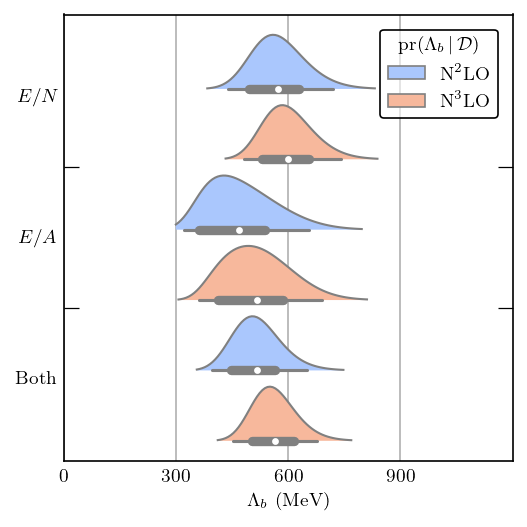

In [34]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
df_Lb_pdf = pd.concat([analysis_n.df_breakdown, analysis_s.df_breakdown, df_Lb_pdf_ns])
df_Lb_pdf = df_Lb_pdf.groupby(['system', 'Order']).apply(scale_lb)
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
        palette="coolwarm", saturation=1., ax=ax, margin=0.3, legend_title=r'pr($\Lambda_b \,|\, \mathcal{D}$)'
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900])
ax.grid(axis='x')
ax.set_axisbelow(True)
# ax.text(
#     0.035, 0.95, r'pr($\Lambda_b \,|\, \mathcal{D}$)',
#     transform=ax.transAxes,
#     ha='left', va='top', bbox=dict(boxstyle='round', facecolor='w')
# )
# ax.legend(*ax.get_legend_handles_labels(), title=)
# ax.set_yticklabels([r'$\displaystyle\frac{E}{N}$', r'$\displaystyle\frac{E}{A}$', 'Both'])
ax.set_yticklabels([r'$E/N$', r'$E/A$', 'Both'])
plt.show()
if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'Lb_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

In [35]:
lb_max_mask = \
    (df_Lb_pdf['Body'] == n_body) & \
    (df_Lb_pdf['system'] == 'All') & \
    (df_Lb_pdf['Order'] == 'N$^3$LO')
lb_max_idx = df_Lb_pdf[lb_max_mask]['pdf'].idxmax()
lb_map = df_Lb_pdf[lb_max_mask].loc[lb_max_idx]['$\Lambda_b$ (MeV)']
lb_map

552.0

In [36]:
lb_median = compute_pdf_median_and_bounds(
    df_Lb_pdf[lb_max_mask]['$\Lambda_b$ (MeV)'], df_Lb_pdf[lb_max_mask]['pdf'], [0.95]
)[0]

In [37]:
lb_median

566.0

In [38]:
450 * np.sqrt(2)

636.3961030678928

Now one for the marginal length scale pdfs. A common length scale for all observables probably isn't necessary, so don't compute an "All" pdf.

In [39]:
# df_ls_pdf = pd.concat([analysis_n.df_ls, analysis_s.df_ls, analysis_d.df_ls])
# ax = pdfplot(
#     x=r'$\ell$ (fm$^{-1}$)', y='system', pdf='pdf', data=df_ls_pdf, hue='Order',
#     order=[r'$E/N$', r'$E/A$', r'$S_2$'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1.,
#         palette="coolwarm", saturation=1., ax=None, margin=0.3,
# )
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1., 1.25, 1.5]);
# ax.set_xlim(0, 1.2)
# ax.grid(axis='x');
# ax.set_axisbelow(True)
# fig = plt.gcf()
# # ax.xaxis.set_minor_locator(AutoMinorLocator(2))
# if savefigs:
#     fig.savefig(
#         analysis_n.figure_name(
#             'ls_pdfs_with_S2_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
#             ls=(ls_min, ls_max, ls_num),
#         )
#     )

In [40]:
df_n_ls_map = analysis_n.df_joint[analysis_n.df_joint['$\Lambda_b$ (MeV)'] == lb_map]
df_s_ls_map = analysis_s.df_joint[analysis_s.df_joint['$\Lambda_b$ (MeV)'] == lb_map]

In [41]:
df_s_ls_map

,$\ell$ (fm$^{-1}$),$\Lambda_b$ (MeV),pdf,Order,Order Index,system,Body
36,0.150000,552.0,4.553090e-06,N$^2$LO,2,$E/A$,NN+3N
137,0.168243,552.0,1.782448e-05,N$^2$LO,2,$E/A$,NN+3N
238,0.186486,552.0,6.733693e-05,N$^2$LO,2,$E/A$,NN+3N
339,0.204730,552.0,2.369798e-04,N$^2$LO,2,$E/A$,NN+3N
440,0.222973,552.0,7.461282e-04,N$^2$LO,2,$E/A$,NN+3N
...,...,...,...,...,...,...,...
14681,1.427027,552.0,6.970683e-09,N$^3$LO,3,$E/A$,NN+3N
14782,1.445270,552.0,5.593879e-09,N$^3$LO,3,$E/A$,NN+3N
14883,1.463514,552.0,4.512669e-09,N$^3$LO,3,$E/A$,NN+3N
14984,1.481757,552.0,3.659412e-09,N$^3$LO,3,$E/A$,NN+3N


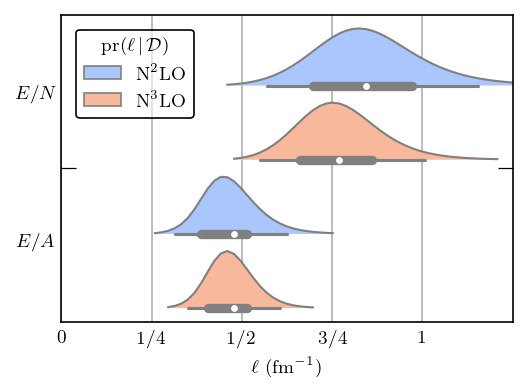

In [42]:
fig, ax = plt.subplots(figsize=(3.4, 2.5))
df_ls_pdf = pd.concat([analysis_n.df_ls, analysis_s.df_ls])
# df_ls_pdf = pd.concat([df_n_ls_map, df_s_ls_map])
ax = pdfplot(
    x=r'$\ell$ (fm$^{-1}$)', y='system', pdf='pdf', data=df_ls_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1.,
        palette="coolwarm", saturation=1., ax=ax, margin=0.3, legend_title=r'pr($\ell \,|\, \mathcal{D}$)'
)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.]);
ax.set_xticklabels(['0', '1/4', '1/2', '3/4', '1'])
ax.set_xlim(0, 1.25)
ax.grid(axis='x');
ax.set_axisbelow(True)

if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'ls_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

/Users/jordan.melendez/repos/nuclear-matter-convergence/nuclear_matter/stats_utils.py:147: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0, w_pad=0)


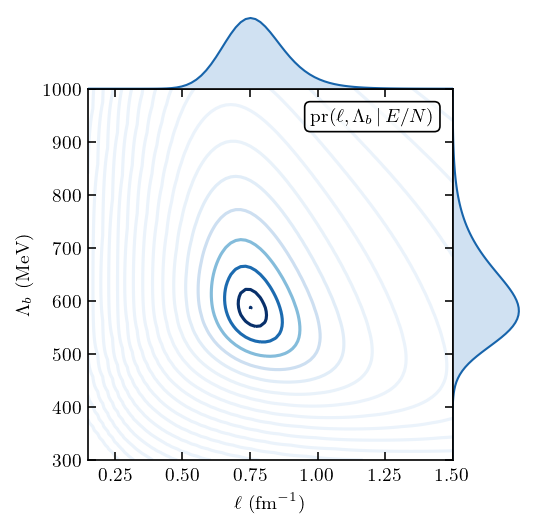

In [43]:
fig = analysis_n.plot_joint_breakdown_ls(max_idx=3)

/Users/jordan.melendez/repos/nuclear-matter-convergence/nuclear_matter/stats_utils.py:147: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0, w_pad=0)


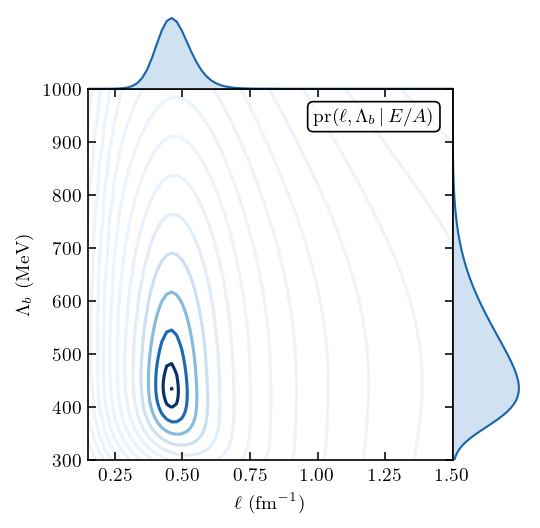

In [44]:
fig = analysis_s.plot_joint_breakdown_ls(max_idx=3)

/Users/jordan.melendez/repos/nuclear-matter-convergence/nuclear_matter/stats_utils.py:147: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0, w_pad=0)


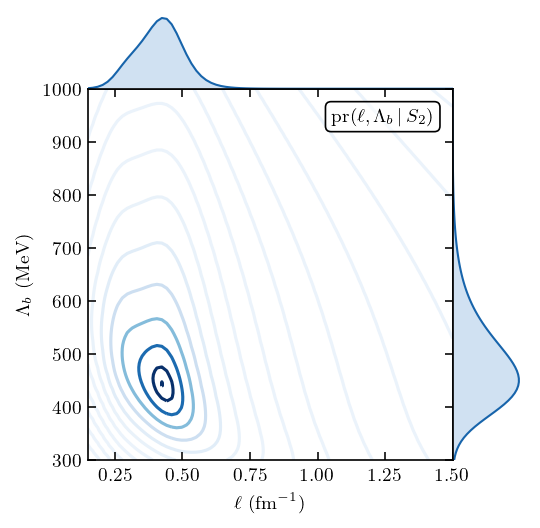

In [45]:
fig = analysis_d.plot_joint_breakdown_ls(max_idx=2)

## Pure Neutron Matter

In [46]:
kernel_n_test = RBF(1.1, 'fixed') + WhiteKernel(0.001, 'fixed')

In [47]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=Lb, interp=False, kernel=kernel_n_test, show_excluded=True)

RBF(length_scale=0.763) + WhiteKernel(noise_level=0.0005)
cbar mean: 0.8684060649936118


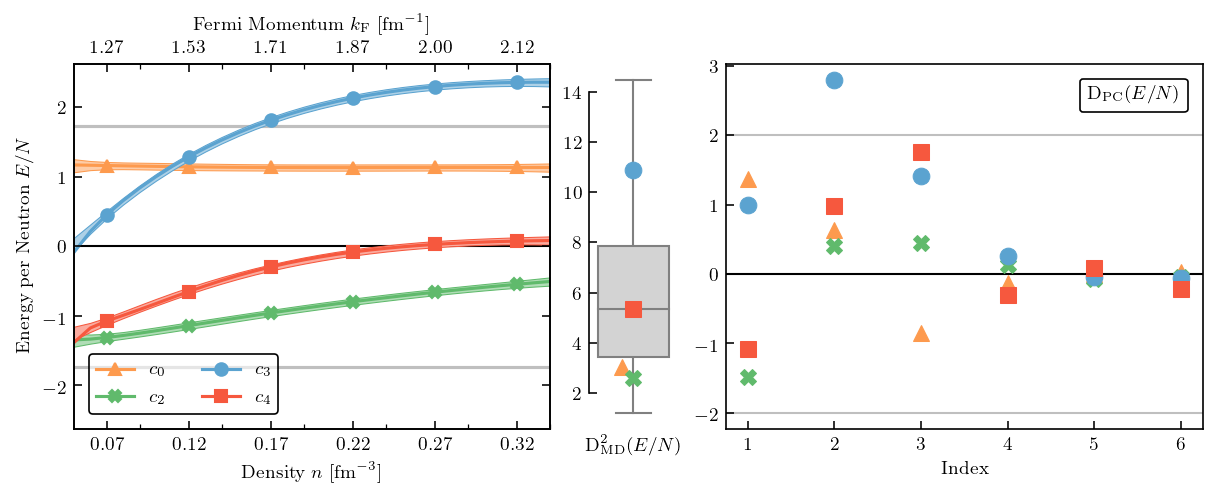

In [48]:
fig = analysis_n.plot_coeff_diagnostics(breakdown=Lb, interp=False, show_excluded=True)

In [49]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=Lb, interp=False)

In [50]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=Lb, interp=True)

In [51]:
analysis_n.n_bodies

[None, None, None, None]

[0 2 3 4]


/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


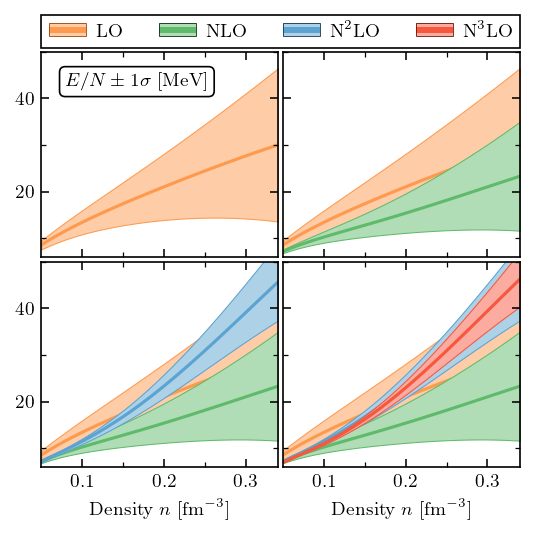

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex=True, sharey='row')
fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
obs_label = r"""$E/N \pm 1\sigma$ [MeV]"""
axes[0,0].text(
    0.1, 0.9, obs_label, transform=axes[0,0].transAxes, ha='left', va='top',
    bbox=dict(boxstyle='round', facecolor='w')
)
axes[0, 0].set_ylim(6, 50)  # Don't show 0 in the top plots, it gets in the way
axes[1, 0].set_ylim(6, 50)
for ax in axes.ravel():
    ax.yaxis.set_major_locator(MultipleLocator(20))
analysis_n.plot_observables(breakdown=Lb, show_process=True, show_excluded=True, ax=axes, panels=True)
plt.show()

In [53]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=None, interp=False)

In [54]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=lb_map)

There's clearly some noise below, we should include it in the kernel. Discuss with Christian about the precision of his calculations.

RBF(length_scale=0.763) + WhiteKernel(noise_level=0.0005)
cbar mean: 0.8684060649936118


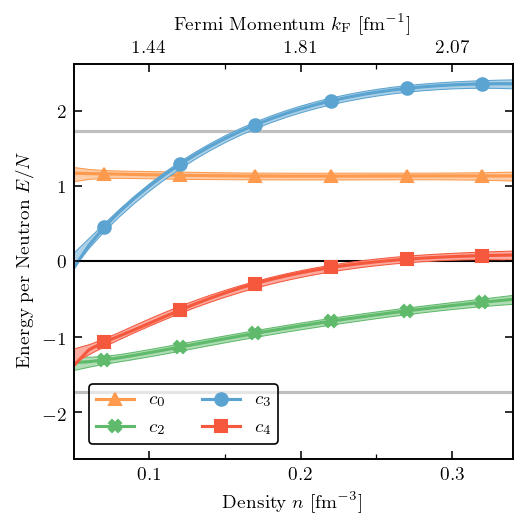

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
analysis_n.plot_coefficients(breakdown=Lb, show_process=True, show_excluded=True, ax=ax, show_train_valid=False)

## Symmetric Nuclear Matter (E/A)

RBF(length_scale=0.466) + WhiteKernel(noise_level=0.0005)
cbar mean: 2.6146499024837073


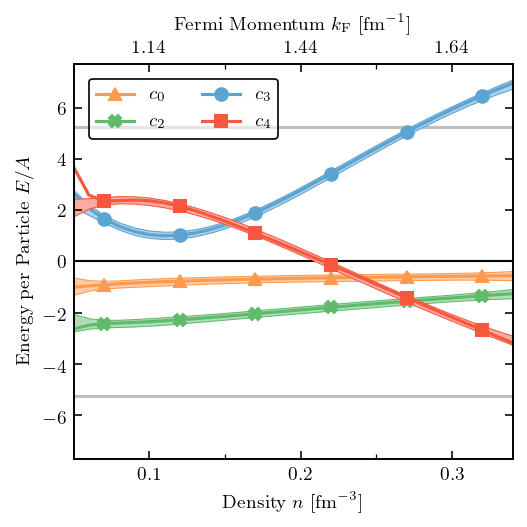

In [56]:
analysis_s.plot_coefficients(breakdown=Lb, show_process=True, show_excluded=True, show_train_valid=False);

In [57]:
kernel

RBF(length_scale=1) + WhiteKernel(noise_level=0.0005)

In [58]:
kernel_s_test = RBF(0.2, 'fixed') + WhiteKernel(0.001, 'fixed')

In [59]:
# fig = analysis_s.plot_coeff_diagnostics(breakdown=Lb, kernel=kernel_s_test)

RBF(length_scale=0.466) + WhiteKernel(noise_level=0.0005)
cbar mean: 2.6146499024837073


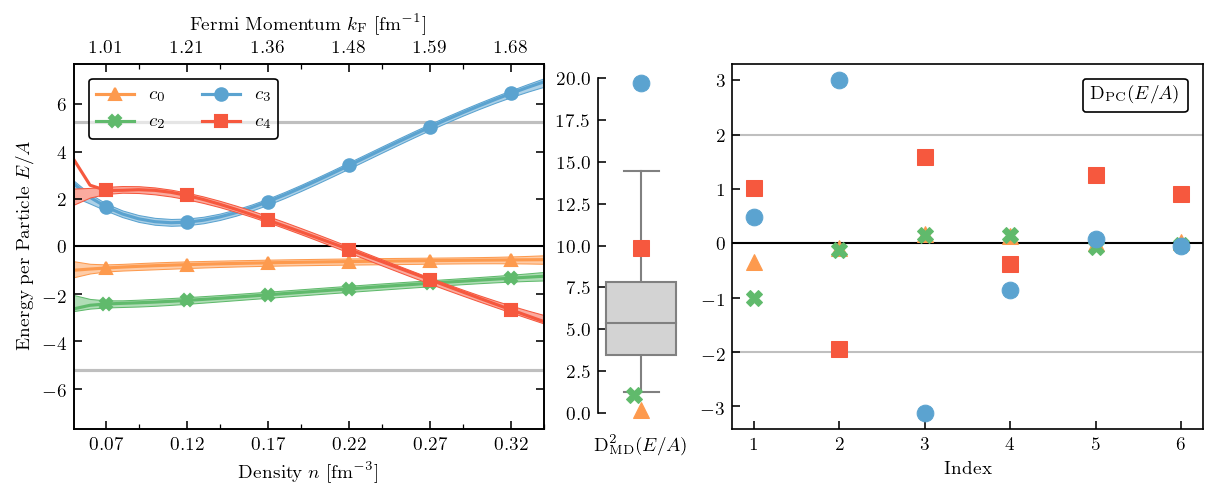

In [60]:
fig = analysis_s.plot_coeff_diagnostics(breakdown=Lb, show_excluded=True)

In [61]:
# fig = analysis_s.plot_coeff_diagnostics(breakdown=lb_map)

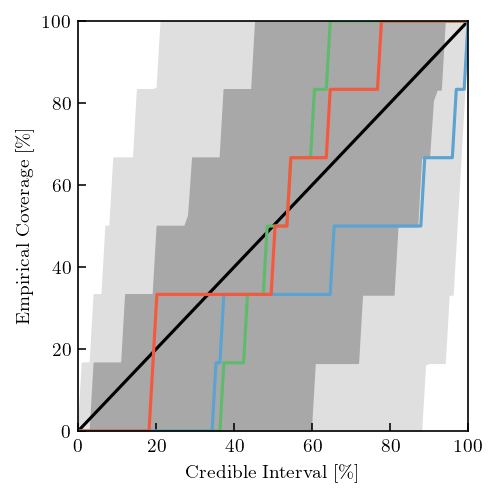

In [62]:
analysis_s.plot_credible_diagnostic(breakdown=Lb);

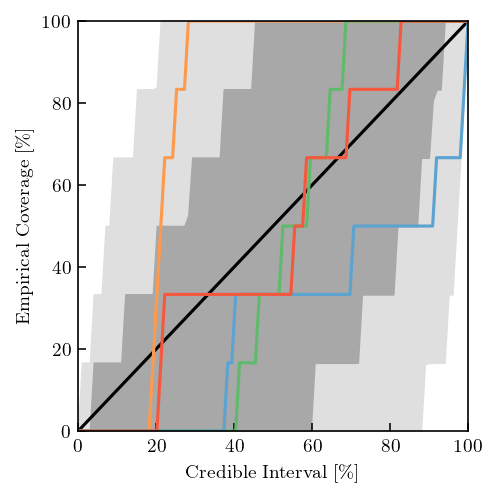

In [63]:
analysis_s.plot_credible_diagnostic(breakdown=Lb, show_excluded=True);

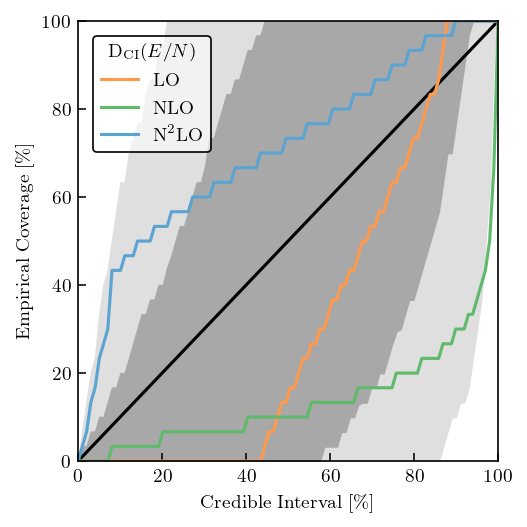

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
analysis_n.plot_credible_diagnostic(breakdown=Lb, truncation=True, show_excluded=True, all_points=True, ax=ax);

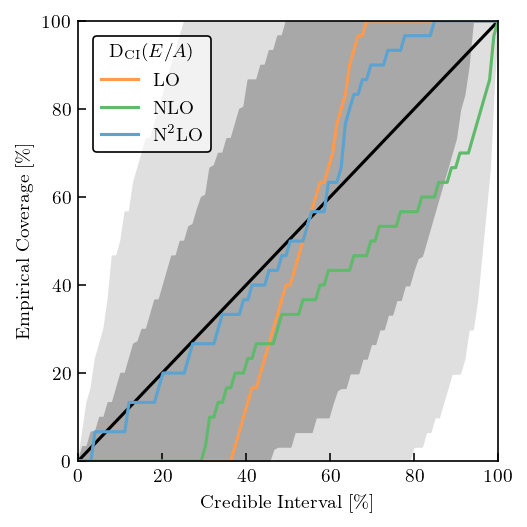

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
analysis_s.plot_credible_diagnostic(breakdown=Lb, truncation=True, show_excluded=True, all_points=True, ax=ax);

In [66]:
order_labels = ['LO', 'NLO', 'N$^2$LO', 'N$^3$LO']

In [67]:
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color) for color in colors]
dark_colors = [darken_color(color) for color in colors]

/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


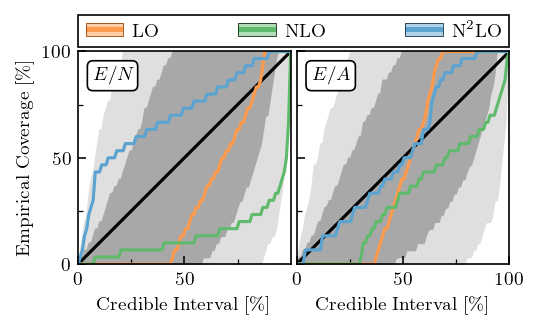

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(3.4, 2.05), sharey=True)
# fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=0.5/72)
fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=0.3/72)

analysis_n.plot_credible_diagnostic(
    breakdown=Lb, truncation=True, show_excluded=True, all_points=True,
    ax=axes[0], show_legend=False, savefig=False
);
analysis_s.plot_credible_diagnostic(
    breakdown=Lb, truncation=True, show_excluded=True, all_points=True,
    ax=axes[1], show_legend=False, ylabel=None, savefig=False
);
# axes[0].set_xticks(axes[0].get_xticks()[:-1])
axes[0].text(
    0.07, 0.93, r'$E/N$', transform=axes[0].transAxes,
    ha='left', va='top',
    bbox=dict(boxstyle='round', facecolor='w'),
)
axes[1].text(
    0.07, 0.93, r'$E/A$', transform=axes[1].transAxes,
    ha='left', va='top',
    bbox=dict(boxstyle='round', facecolor='w')
)
axes[0].set_xticks([0, .50])
axes[0].set_xticklabels([0, 50])
axes[0].set_xticks([.25, .75], minor=True)
axes[1].set_xticks([0, 0.50, 1.00])
axes[1].set_xticklabels([0, 50, 100])
axes[1].set_xticks([.25, .75], minor=True)
axes[0].set_aspect(1)
axes[1].set_aspect(1)
for ax in axes.ravel():
    ax.set_yticks([0, 0.50, 1.00])
    ax.set_yticklabels([0, 50, 100])
    ax.set_yticks([0.25, 0.75], minor=True)
    
add_top_order_legend(fig, axes[0], axes[1], order_labels[:-1], colors, light_colors, dark_colors)
fig.savefig(join(fig_path, f'both_pnm_snm_ci_diagnostics_lambda-{Lambda}'))
plt.show()


In [69]:
# fig = analysis_s.plot_coeff_diagnostics(breakdown=None)

[0 2 3 4]


/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


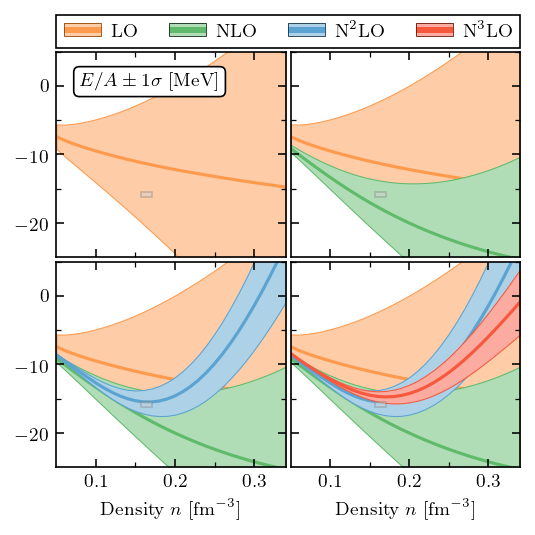

In [70]:
# fig, ax = plt.subplots(1,1, figsize=(3.4, 3.4))
# axes = np.atleast_2d(ax)
fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex=True, sharey=True)
fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
obs_label = r"""$E/A \pm 1\sigma$ [MeV]"""
axes[0,0].text(
    0.1, 0.9, obs_label, transform=axes[0,0].transAxes, ha='left', va='top',
    bbox=dict(boxstyle='round', facecolor='w')
)
for ax in axes.ravel():
    ax.set_ylim(-25, 5)
analysis_s.plot_observables(breakdown=Lb, show_process=True, show_excluded=True, ax=axes, panels=True)
plt.show()

In [71]:
n_samples = 3000

if high_density:
    kf_s_dense = np.linspace(kf_s[3:].min(), kf_s[:].max(), 150)
    sat_conditioned = slice(None, None, 4)
else:
    kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 100)
    sat_conditioned = slice(None, None, 2)
Kf_s_dense = kf_s_dense[:, None]

# The points to fit the GP to (but hyperparameter training is still at "train")


In [72]:
lb_map

552.0

RBF(length_scale=0.466) + WhiteKernel(noise_level=0.0005)
Order 3
x: 0.1673318920278251 +/- 0.018000274890797155
y: -15.734337025269587 +/- 1.9497293317527498
RBF(length_scale=0.466) + WhiteKernel(noise_level=0.0005)
Order 4
x: 0.1724722669058518 +/- 0.012356056748915992
y: -14.865826533925429 +/- 0.9182561056279218
manuscript_figures/sat_ellipse_ords-3-4_sys-s_NN+3N_fit-1-7_Lamb-450_Q-kf_Lb-600_ls-x_midx-x_hyp-0-0-10-0p8


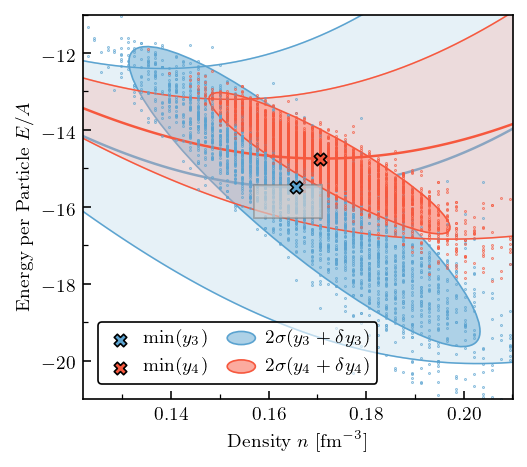

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 3))
np.random.seed(1)

ax.set_xlim(0.122, 0.21)
if Lambda == 500:
    ax.set_ylim(-19.3, -10.1)
elif Lambda == 450:
    ax.set_ylim(-21, -11)
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
analysis_s.plot_multi_saturation(
    breakdown=Lb, orders=[3,4], nugget=1e-5, X=Kf_s_dense,
    cond=sat_conditioned, n_samples=n_samples, ax=ax, savefig=True,
    is_density_primary=True,
    legend_kwargs=dict(ncol=2, columnspacing=1, handletextpad=0.5, handlelength=1.5, loc='lower left'),
)
# ax.set_xlim(None, 0.22)
# ax.set_ylim(-20, -10)


In [74]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
# np.random.seed(1)
# analysis_s.plot_multi_saturation(
#     breakdown=Lb, orders=[3,4], nugget=1e-6, X=Kf_s,
#     cond=train,
#     n_samples=n_samples, ax=ax, savefig=False
# );

In [75]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
# np.random.seed(1)
# analysis_s.plot_multi_saturation(
#     breakdown=320., orders=[3,4], nugget=1e-5, X=Kf_s,
#     cond=train,
#     n_samples=n_samples, ax=ax, savefig=False
# );

In [76]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
# np.random.seed(1)
# analysis_s.plot_multi_saturation(
#     orders=[3,4], nugget=1e-5, X=Kf_s_dense,
#     cond=sat_conditioned, n_samples=n_samples, ax=ax, savefig=True
# );

## Symmetry Energy

In [77]:
from nuclear_matter.stats_utils import create_truncation_multi_covariance, create_rbf_multi_covariance, \
    create_sym_energy_rbf_covariance, create_sym_energy_truncation_covariance

In [78]:
def plot_cross_covariance(x, cov, label1=r'$E/A$', label2=r'$E/N$', ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.4, 3.4))
    # ax.contourf(x_test_twice, x_test_twice[::-1], cov_test, levels=100)
    x = x - x[0]
    x_max = x[-1]
    x_min = x[0]
    ax.imshow(
        cov, origin='upper', interpolation='bilinear', cmap='cividis',
        extent=(x_min, 2*x_max, x_min, 2*x_max), **kwargs
    )
#     ax.pcolormesh(
#         cov,
# #         origin='upper', interpolation='bilinear', cmap='cividis',
# #         extent=(x_min, 2*x_max, x_min, 2*x_max)
#     )
    ax.axhline(x_max, 0, 1, c='k', lw=0.8)
    ax.axvline(x_max, 0, 1, c='k', lw=0.8)
    ax.set_xticks([x_max/2, 3 * x_max / 2])
    ax.set_xticklabels([label1, label2])
    ax.set_yticks([x_max/2, 3 * x_max / 2])
    ax.set_yticklabels([label2, label1])
#     x_labels = x[::6]
#     ax.set_yticks(np.arange(len(x_labels)))
# #     ax.set_yticks(x_labels)
# #     ax.set_yticklabels(x_labels)
#     ax.set_xticks(np.arange(len(x_labels)))
# #     ax.set_xticks(x_labels)
# #     ax.set_xticklabels(x_labels)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    return ax

In [223]:
from nuclear_matter.stats_utils import cov_no_centering, CorrKernel

In [191]:
en_true_coeffs = analysis_n.compute_coefficients(breakdown=Lb, show_excluded=True)
ea_true_coeffs = analysis_s.compute_coefficients(breakdown=Lb, show_excluded=True)
c_both_flat = np.stack((en_true_coeffs[:, 1:].ravel(), ea_true_coeffs[:, 1:].ravel()), axis=0).T
cov_en_ea_empirical = cov_no_centering(*c_both_flat.T)

In [192]:
rho_empirical = cov_en_ea_empirical[1, 0] / np.sqrt(cov_en_ea_empirical[0, 0] * cov_en_ea_empirical[1, 1])

In [228]:
cbar_n, kern_fit_n = analysis_n.compute_std_and_kernel(breakdown=Lb)
cbar_s, kern_fit_s = analysis_s.compute_std_and_kernel(breakdown=Lb)

ls_n = kern_fit_n.k1.get_params()['length_scale']
ls_s = kern_fit_s.k1.get_params()['length_scale']

# TESTING:
# cbar_s = cbar_n
# ls_s = ls_n

print(cbar_n, ls_n)
print(cbar_s, ls_s)

kf_conversion_factor = 2 ** (1/3.)
ls_s_scaled = kf_conversion_factor * ls_s

# rho_corr = np.sqrt(2 * ls_n * ls_s / (ls_n**2 + ls_s**2))




if Lambda == 450:
    rho_sym_energy = rho_corr = rho_empirical
    ls1 = (ls_s + ls_n) / 2
    ls2 = None
else:
    rho_sym_energy = None
    rho_corr = np.sqrt(2 * ls_n * ls_s_scaled / (ls_n**2 + ls_s_scaled**2))
    ls1 = ls_n
    ls2 = ls_s_scaled


print('rho', rho_corr, rho_sym_energy)
    
kf_n_linear = np.linspace(kf_n[0], kf_n[-1], len(kf_n))
kf_s_linear = np.linspace(kf_s[0], kf_s[-1], len(kf_s))
Kf_n_linear = kf_n_linear[:, None]
Kf_s_linear = kf_s_linear[:, None]

kf_linear = np.linspace(0, 2, 101)
Kf_linear = kf_linear[:, None]

K_multi_ns = create_truncation_multi_covariance(
    Kf_n, Kf_s, cbar_n, cbar_s, ls1, ls2,
    ref_2bf_func_n(Kf_n), ref_2bf_func_s(Kf_s),
    ratio_kf(Kf_n, breakdown=Lb), ratio_kf(Kf_n, breakdown=Lb),
    kmin=4, nugget=1e-12, rho=rho_sym_energy
)

# This is just for show, so use same linear Kf's and cbar = 1

corr_multi_coeff_ns = create_rbf_multi_covariance(
    Kf_linear, Kf_linear, 1, 1,
    ls_n, ls_s_scaled,
    nugget=1e-13, rho=rho_sym_energy
)
K_multi_coeff_ns = create_rbf_multi_covariance(
    Kf_n, Kf_s, cbar_n, cbar_s, ls1, ls2, nugget=1e-10,
    rho=rho_sym_energy
)
K_d_coeff = create_sym_energy_rbf_covariance(
    density, cbar_n, cbar_s, ls1, ls2, nugget=1e-15,
    rho=rho_sym_energy
)
corr_d_coeff = create_sym_energy_rbf_covariance(
    density, 1, 1, ls1, ls2, nugget=1e-15, rho=rho_sym_energy
)

std_d_truncs = {}
for i, n in enumerate(orders):
    kmin = n+1 if n != 0 else 2
    
    K_d_trunc = create_sym_energy_truncation_covariance(
        density, cbar_n, cbar_s, ls1, ls2,
        ref_2bf_func_n(Kf_n), ref_2bf_func_s(Kf_s),
        ratio_kf(Kf_n, breakdown=Lb), ratio_kf(Kf_s, breakdown=Lb),
        kmin=kmin, nugget=1e-10, rho=rho_sym_energy
    )
    std_d_trunc = np.sqrt(np.diag(K_d_trunc))
    std_d_truncs[n] = std_d_trunc

0.8684060649936118 0.7631421388401067
2.6146499024837073 0.46603268529311087
rho 0.7487252942146571 0.7487252942146571


In [229]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [230]:
print(ls_n, ls_s_scaled)

0.7631421388401067 0.5871643901398232


In [231]:
y_n_2_plus_3bf.shape

(30, 4)

In [232]:
y_both_2_plus_3bf = np.concatenate((y_n_2_plus_3bf, y_s_2_plus_3bf))

In [233]:
y_both_2_plus_3bf.shape

(60, 4)

In [234]:
kf_n_twice = np.concatenate((kf_n, kf_n))
kf_n_linear_twice = np.concatenate((kf_n_linear, kf_n_linear))

In [235]:
kf_n_twice.shape

(60,)

In [236]:
kf_n_twice

array([1.13972, 1.21113, 1.27499, 1.33302, 1.3864 , 1.43595, 1.48231,
       1.52593, 1.56719, 1.60639, 1.64376, 1.6795 , 1.71379, 1.74675,
       1.77852, 1.80919, 1.83885, 1.86759, 1.89547, 1.92255, 1.94889,
       1.97453, 1.99953, 2.02392, 2.04773, 2.071  , 2.09376, 2.11604,
       2.13786, 2.15924, 1.13972, 1.21113, 1.27499, 1.33302, 1.3864 ,
       1.43595, 1.48231, 1.52593, 1.56719, 1.60639, 1.64376, 1.6795 ,
       1.71379, 1.74675, 1.77852, 1.80919, 1.83885, 1.86759, 1.89547,
       1.92255, 1.94889, 1.97453, 1.99953, 2.02392, 2.04773, 2.071  ,
       2.09376, 2.11604, 2.13786, 2.15924])

In [237]:
RBF(0.6, (0.1, 3))(kf_n)

array([[1.]])

In [238]:
# coregional_kernel = CorrKernel(0.5, (0.2, 1), std1=cbar_n, std2=cbar_s) * RBF(0.6, (0.1, 3))
# coregional_kernel = CorrKernel(0.95, (0.5, 1)) * RBF(0.6, (0.4, 1.0))# + WhiteKernel(nugget/2)
# coregional_kernel = CorrKernel(0.95, (0.5, 1), std1=cbar_n, std2=cbar_s) * RBF((ls_n + ls_s) / 2, 'fixed')
coregional_kernel = CorrKernel(0.85, (0.5, 1), std1=cbar_n, std2=cbar_s) * RBF(0.6, (0.1, 3))

In [239]:
gp_coregion = GaussianProcessRegressor(coregional_kernel, alpha=1e-10, n_restarts_optimizer=5)

In [240]:
c_both_2_plus_3bf = np.concatenate((
    analysis_n.compute_coefficients(breakdown=Lb),
    analysis_s.compute_coefficients(breakdown=Lb)
))

In [241]:
# plt.plot(kf_n_twice, c_both_2_plus_3bf)

In [242]:
gp_coregion.fit(kf_n_twice[:, None], c_both_2_plus_3bf)

/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=CorrKernel(rho=0.85) * RBF(length_scale=0.6),
                         n_restarts_optimizer=5, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [243]:
gp_coregion.kernel_

CorrKernel(rho=0.5) * RBF(length_scale=0.181)

In [244]:
kf_n

array([1.13972, 1.21113, 1.27499, 1.33302, 1.3864 , 1.43595, 1.48231,
       1.52593, 1.56719, 1.60639, 1.64376, 1.6795 , 1.71379, 1.74675,
       1.77852, 1.80919, 1.83885, 1.86759, 1.89547, 1.92255, 1.94889,
       1.97453, 1.99953, 2.02392, 2.04773, 2.071  , 2.09376, 2.11604,
       2.13786, 2.15924])

/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  func(*args, **kwargs)
/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


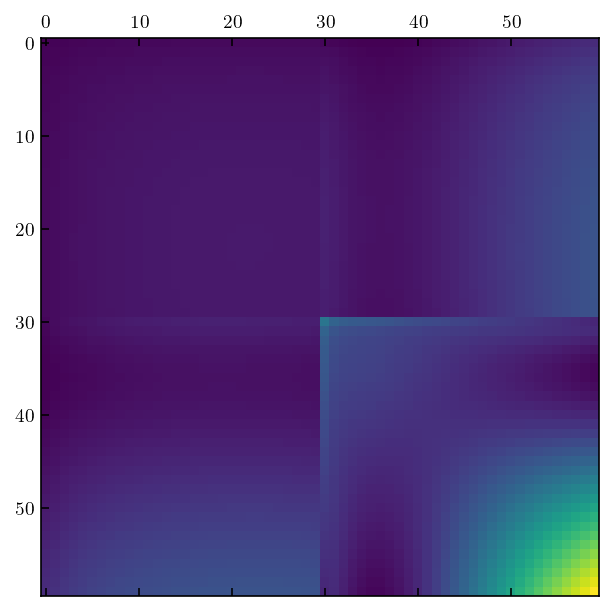

In [245]:
plt.matshow(np.cov(c_both_2_plus_3bf))

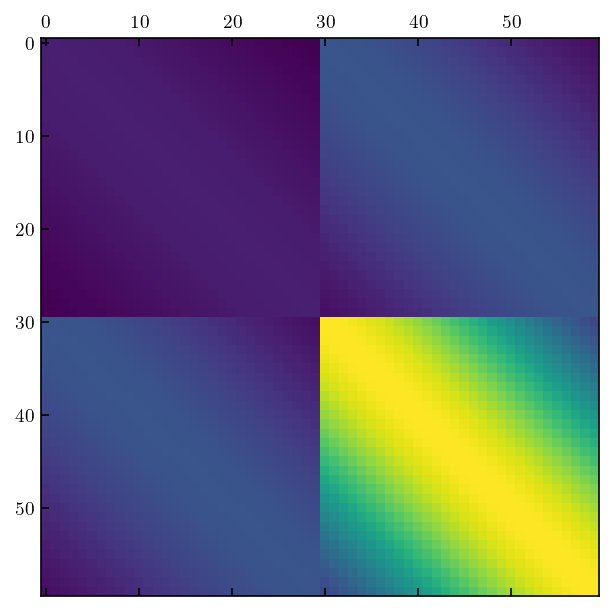

In [246]:
plt.matshow(coregional_kernel(kf_n_linear_twice[:, None]))

In [247]:
coregional_kernel.hyperparameters

[Hyperparameter(name='k1__rho', value_type='numeric', bounds=array([[0.5, 1. ]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[0.1, 3. ]]), n_elements=1, fixed=False)]

In [248]:
coregional_kernel.hyperparameters

[Hyperparameter(name='k1__rho', value_type='numeric', bounds=array([[0.5, 1. ]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[0.1, 3. ]]), n_elements=1, fixed=False)]

In [249]:
coregional_kernel(kf_n_twice[:, None])

array([[0.75412909, 0.74880686, 0.73520525, ..., 0.51356715, 0.48373811,
        0.4556069 ],
       [0.74880686, 0.75412909, 0.74986976, ..., 0.61891145, 0.58549249,
        0.55378749],
       [0.73520525, 0.74986976, 0.75412909, ..., 0.72257352, 0.68620809,
        0.65151549],
       ...,
       [0.51356715, 0.61891145, 0.72257352, ..., 6.83639411, 6.83187492,
        6.81869712],
       [0.48373811, 0.58549249, 0.68620809, ..., 6.83187492, 6.83639411,
        6.83205529],
       [0.4556069 , 0.55378749, 0.65151549, ..., 6.81869712, 6.83205529,
        6.83639411]])

In [250]:
kf_s * kf_conversion_factor

array([1.13971198, 1.21112431, 1.27498971, 1.33302167, 1.38639192,
       1.43595722, 1.48230971, 1.52592818, 1.5671906 , 1.60638674,
       1.643756  , 1.67949996, 1.71378241, 1.74675454, 1.77851715,
       1.80918363, 1.83885477, 1.86759357, 1.89546303, 1.92255133,
       1.94888368, 1.97453567, 1.9995325 , 2.02392458, 2.04773708,
       2.07100782, 2.093762  , 2.1160374 , 2.13785924, 2.1592401 ])

In [251]:
np.concatenate((kf_n, kf_s))

array([1.13972, 1.21113, 1.27499, 1.33302, 1.3864 , 1.43595, 1.48231,
       1.52593, 1.56719, 1.60639, 1.64376, 1.6795 , 1.71379, 1.74675,
       1.77852, 1.80919, 1.83885, 1.86759, 1.89547, 1.92255, 1.94889,
       1.97453, 1.99953, 2.02392, 2.04773, 2.071  , 2.09376, 2.11604,
       2.13786, 2.15924, 0.90459, 0.96127, 1.01196, 1.05802, 1.10038,
       1.13972, 1.17651, 1.21113, 1.24388, 1.27499, 1.30465, 1.33302,
       1.36023, 1.3864 , 1.41161, 1.43595, 1.4595 , 1.48231, 1.50443,
       1.52593, 1.54683, 1.56719, 1.58703, 1.60639, 1.62529, 1.64376,
       1.66182, 1.6795 , 1.69682, 1.71379])

In [252]:
2 ** (1./3)

1.2599210498948732

In [253]:
np.diag(K_d_coeff) / (cbar_s)

array([1.60267923, 1.60267923, 1.60267923, 1.60267923, 1.60267923,
       1.60267923, 1.60267923, 1.60267923, 1.60267923, 1.60267923,
       1.60267923, 1.60267923, 1.60267923, 1.60267923, 1.60267923,
       1.60267923, 1.60267923, 1.60267923, 1.60267923, 1.60267923,
       1.60267923, 1.60267923, 1.60267923, 1.60267923, 1.60267923,
       1.60267923, 1.60267923, 1.60267923, 1.60267923, 1.60267923])

In [254]:
cbar_n, cbar_s, np.sqrt(np.diag(K_d_coeff) / (cbar_n))

(0.8684060649936118,
 2.6146499024837073,
 array([2.19668939, 2.19668939, 2.19668939, 2.19668939, 2.19668939,
        2.19668939, 2.19668939, 2.19668939, 2.19668939, 2.19668939,
        2.19668939, 2.19668939, 2.19668939, 2.19668939, 2.19668939,
        2.19668939, 2.19668939, 2.19668939, 2.19668939, 2.19668939,
        2.19668939, 2.19668939, 2.19668939, 2.19668939, 2.19668939,
        2.19668939, 2.19668939, 2.19668939, 2.19668939, 2.19668939]))

In [255]:
np.diag(corr_d_coeff)

array([0.50254941, 0.50254941, 0.50254941, 0.50254941, 0.50254941,
       0.50254941, 0.50254941, 0.50254941, 0.50254941, 0.50254941,
       0.50254941, 0.50254941, 0.50254941, 0.50254941, 0.50254941,
       0.50254941, 0.50254941, 0.50254941, 0.50254941, 0.50254941,
       0.50254941, 0.50254941, 0.50254941, 0.50254941, 0.50254941,
       0.50254941, 0.50254941, 0.50254941, 0.50254941, 0.50254941])

In [256]:
np.sqrt(np.diag(corr_d_coeff))

array([0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072,
       0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072,
       0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072,
       0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072,
       0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072, 0.7089072])

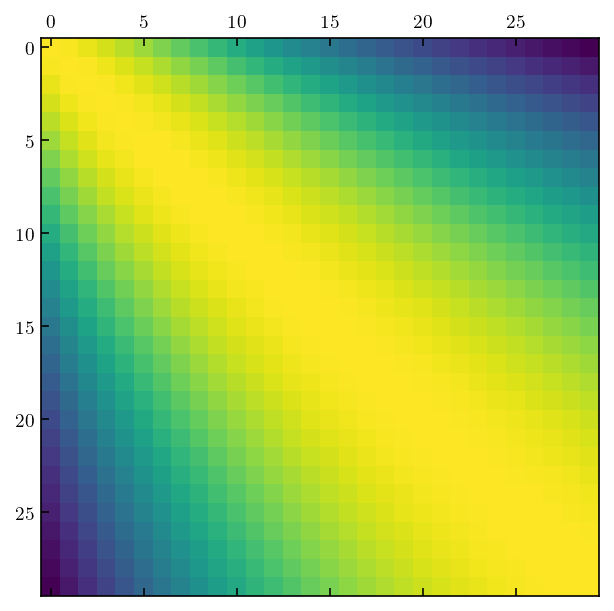

In [257]:
plt.matshow(K_d_coeff)

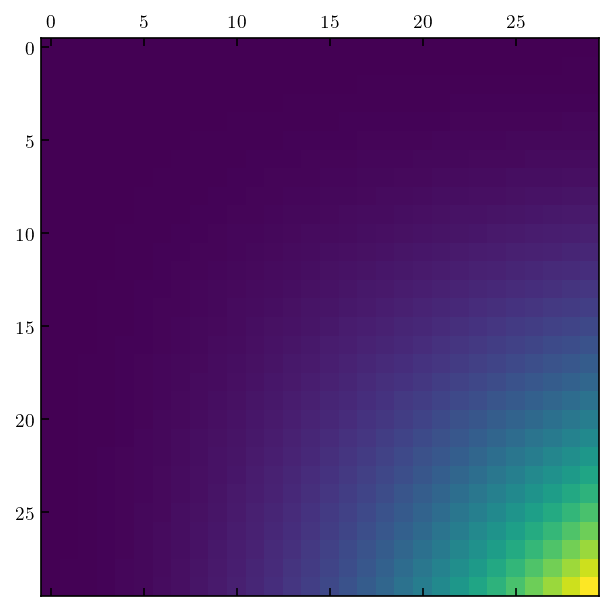

In [258]:
plt.matshow(K_d_trunc)

In [259]:
np.linalg.eigh(K_d_trunc)

(array([1.99992143e-10, 1.99996562e-10, 1.99997623e-10, 1.99998772e-10,
        1.99999811e-10, 1.99999891e-10, 1.99999921e-10, 2.00000207e-10,
        2.00000339e-10, 2.00000653e-10, 2.00000974e-10, 2.00003849e-10,
        2.00007011e-10, 2.00011092e-10, 2.00011491e-10, 2.00053828e-10,
        2.01098773e-10, 2.02874983e-10, 2.27377503e-10, 3.37507867e-10,
        7.70576732e-10, 6.95736110e-09, 2.13580246e-08, 2.94653039e-07,
        8.85905219e-06, 2.19758929e-04, 4.74287492e-03, 1.01094147e-01,
        2.47343195e+00, 8.97451814e+01]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  3.65021747e-02,  0.00000000e+00,
          2.00697763e-01,  4.23178752e-03,  2.41759874e-01,
         -4.40435907e-02,  3.34001871e-01, -8.92644725e-02,
         -4.19793716e-01,  1.38366

In [260]:
rho_sym_energy

0.7487252942146571

/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


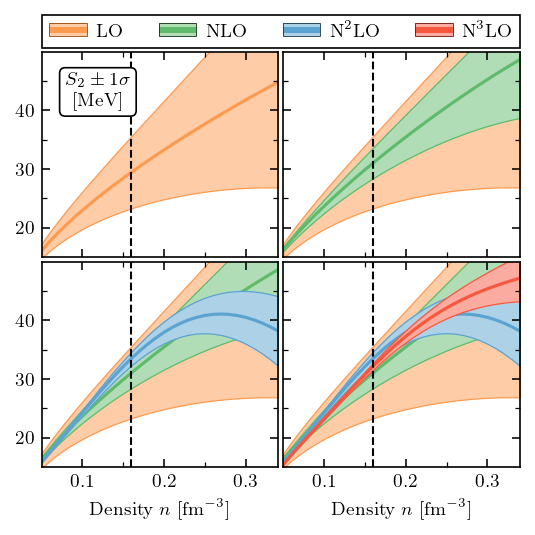

In [261]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex=True, sharey=True)
    for j in range(len(orders)):
        ax = axes.ravel()[j]
        ax.axvline(0.16, 0, 1, c='k', ls='--', lw=1, zorder=3)
        ax.set_ylim(15, 49.999)
        ax.set_xlim(density[0], density[-1])
        ax.tick_params(right=True, top=True, which='both')
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))

        for i, n in enumerate(orders[:j+1]):
            ax.plot(density, y_d_2_plus_3bf[:, i], c=colors[i], zorder=i/10)
            std_d_trunc = std_d_truncs[n]
            ax.fill_between(
                density, y_d_2_plus_3bf[:, i] + std_d_trunc,
                y_d_2_plus_3bf[:, i] - std_d_trunc,
                facecolor=lighten_color(colors[i]), edgecolor=colors[i],
                lw=0.6, zorder=i/10
            )
    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
    axes[1, 0].set_xlabel('Density $n$ [fm$^{-3}$]')
    axes[1, 1].set_xlabel('Density $n$ [fm$^{-3}$]')
    label = r"""$S_2 \pm 1\sigma$
    [MeV]"""
    axes[0, 0].text(
        0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
        multialignment='center',
        bbox=dict(facecolor='w', boxstyle='round')
    )
    add_top_order_legend(fig, axes[0, 0], axes[0, 1], order_labels, colors, light_colors, dark_colors)
    fig.savefig(path.join(fig_path, f'S2_order-by-order-Lambda-{Lambda}'))
    plt.show()



In [262]:
from matplotlib.colors import LogNorm

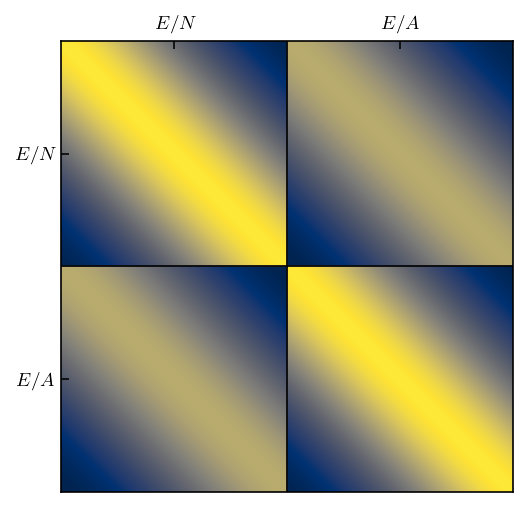

In [263]:
ax = plot_cross_covariance(density, corr_multi_coeff_ns, label1=r'$E/N$', label2=r'$E/A$')
fig = plt.gcf()
fig.savefig(path.join(fig_path, f'EN_EA_full_correlation_matrix_Lambda-{Lambda}'))

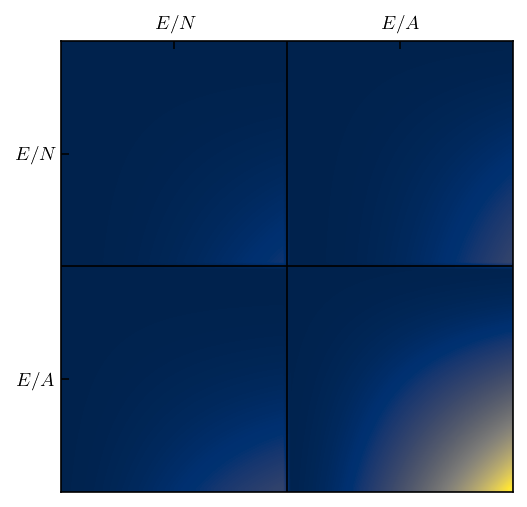

In [264]:
plot_cross_covariance(density, K_multi_ns, label1=r'$E/N$', label2=r'$E/A$')

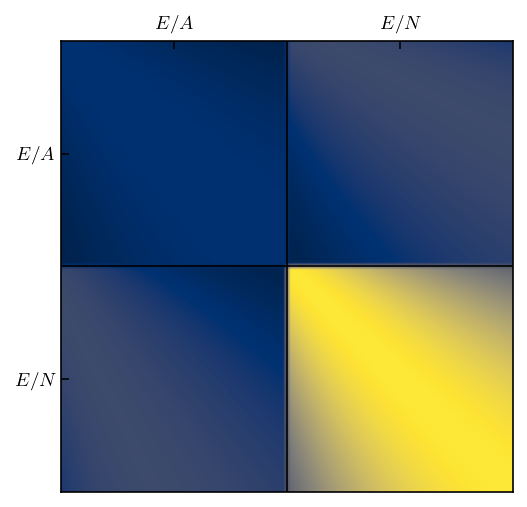

In [265]:
plot_cross_covariance(density, K_multi_coeff_ns)

In [268]:
n_coeff_samples = 10
np.random.seed(1)
en_ea_coeff_samples = stats.multivariate_normal(
    mean=np.zeros(2*density.shape[0]), cov=K_multi_coeff_ns, allow_singular=True).rvs(n_coeff_samples).T
en_coeff_samples = en_ea_coeff_samples[:density.shape[0]]
ea_coeff_samples = en_ea_coeff_samples[density.shape[0]:]

mean_samples = np.zeros(2)


cov_samples = np.array([
    [cbar_n**2, cbar_n * cbar_s * rho_corr],
    [cbar_n * cbar_s * rho_corr, cbar_s**2]
])

In [269]:
print('rho empirical:', rho_empirical)
print('rho coregional:', rho_corr)

rho empirical: 0.7487252942146571
rho coregional: 0.7487252942146571


In [270]:
print('std empirical:')
print('   E/N', np.sqrt(cov_en_ea_empirical[0, 0]))
print('   E/A', np.sqrt(cov_en_ea_empirical[1, 1]))

print('std coregional:')
print('   E/N', cbar_n)
print('   E/A', cbar_s)

std empirical:
   E/N 1.2473582325949928
   E/A 2.736402236338689
std coregional:
   E/N 0.8684060649936118
   E/A 2.6146499024837073


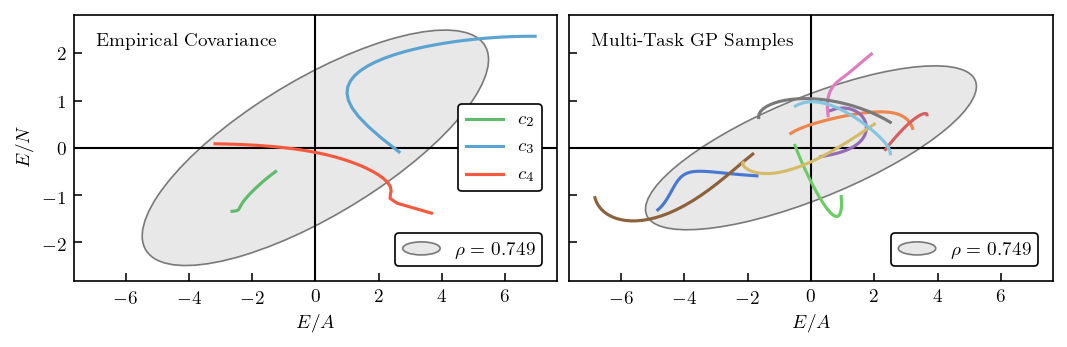

In [271]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2.2), sharex=True, sharey=True)

ellipse_label_empirical = fr'$\rho = {rho_empirical:0.3f}$'
ellipse_emp = confidence_ellipse_mean_cov(
    mean_samples, cov_en_ea_empirical[::-1, ::-1], axes[0], n_std=2,
    facecolor='lightgrey', edgecolor='k', alpha=0.5, zorder=-2,
#     label=ellipse_label_empirical
)

# Create a legend for the ellipse.
first_legend = axes[0].legend(handles=[ellipse_emp], labels=[ellipse_label_empirical], loc='lower right')

# Add the legend manually to the current Axes.
axes[0].add_artist(first_legend)

# axes[0].text(
#     0.24, 0.92, ellipse_label_empirical, transform=axes[0].transAxes,
#     ha='left', va='top', bbox=dict(boxstyle='round', facecolor='w')
# )

axes[0].axhline(0, 0, 1, c='k', lw=1)
axes[0].axvline(0, 0, 1, c='k', lw=1)

for i, n in enumerate(orders):
    if n == 0:
        continue
    
    axes[0].plot(ea_true_coeffs[:, i], en_true_coeffs[:, i], c=colors[i], label=fr'$c_{{{n}}}$')

axes[0].set_ylabel(r'$E/N$')
axes[0].set_xlabel(r'$E/A$')

confidence_ellipse_mean_cov(
    mean_samples, cov_samples[::-1, ::-1], axes[1], n_std=2,
    facecolor='lightgrey', edgecolor='k', alpha=0.5, zorder=-2,
    label=fr'$\rho = {rho_corr:0.3f}$'
)

axes[1].set_xlabel(r'$E/A$')

axes[1].axhline(0, 0, 1, c='k', lw=1)
axes[1].axvline(0, 0, 1, c='k', lw=1)
for i in range(n_coeff_samples):
    axes[1].plot(ea_coeff_samples[:, i], en_coeff_samples[:, i], c=sns.color_palette('muted')[i])

xlim = np.max(np.abs([*axes[0].get_xlim(), *axes[1].get_xlim()]))
ylim = np.max(np.abs([*axes[0].get_ylim(), *axes[1].get_ylim()]))
for ax in axes:
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)

# axes[0].set_aspect(1.5)
# axes[1].set_aspect(1.5)
axes[0].legend(loc='right', framealpha=1)
axes[0].text(
    0.045, 0.93, 'Empirical Covariance', transform=axes[0].transAxes,
    ha='left', va='top',
)


axes[1].text(
    0.045, 0.93, 'Multi-Task GP Samples', transform=axes[1].transAxes,
    ha='left', va='top',
#     bbox=dict(boxstyle='round', facecolor='w')
)
axes[1].legend(loc='lower right')
fig.savefig(path.join(fig_path, f'empirical_correlation_ellipses_coefficients_Lambda-{Lambda}'))


In [ ]:
K_multi_ns

In [ ]:
np.linalg.eigh(K_multi_ns)

In [ ]:
fig = analysis_d.plot_coeff_diagnostics(breakdown=Lb)

In [ ]:
fig = analysis_d.plot_coeff_diagnostics(breakdown=None)

In [ ]:
fig = analysis_d.plot_coeff_diagnostics(breakdown=lb_map)

In [ ]:
# fig = analysis_d.plot_observables(breakdown=Lb, show_process=True)

In [ ]:
# fig = analysis_d.plot_observables(breakdown=None, show_process=True)

In [ ]:
# fig.savefig('test', metadata=dict(Keywords='??'))